<h3 align="center">Instituto Tecnológico de Aeronáutica - ITA</h3>

<h3 align="center">Introdução a Ciência de Dados - CMC-13</h3>

<h3 align="center">Equipe: Fernando Zanchitta, Guilherme Kowalczuk, Rafael Frisch e Yuri Gama</h3>

---

# Laboratório de Exame

O objetivo desse laboratório é exercitar e fixar os conhecimentos aprendidos em CMC-13 por meio da prática de técnicas de Ciência de Dados em uma base de dados fornecida. Para isso, foi utilizado o *dataset* de dados sobre imóveis no Reino Unido e seus respectivos preços. O objetivo desse laboratório é prever o preço de um imóvel a partir de suas características utilizando técnicas de regressão baseadas em Redes Neurais do tipo MLP e em Árvores de Decisão. Por fim, é realizado um estudo comparativo entre os dois modelos, com o intuito de verificar qual deles apresenta melhor desempenho para o problema em questão. Para isso, são avaliados medidas de desempenho diversas. Por fim, aplicamos o modelo em um conjunto de dados de teste para verificar o desempenho do modelo em dados não vistos.

## 0. Aquisição dos dados:

Nessa etapa vamos fazer o download do conjunto de dados a ser utilizado. Essa etapa é opcional caso os dados já estejam no diretório do projeto. Caso não haja o pacote `gdown` em Python e o arquivo já esteja no diretório do projeto, basta comentar essa linha de código.

In [1]:
!gdown 16tT3wHeWoUvlp9pEi3E4Q9L_msZr5v-t

Downloading...
From: https://drive.google.com/uc?id=16tT3wHeWoUvlp9pEi3E4Q9L_msZr5v-t
To: /Users/kowalks/dev/cmc13-exame/UK_real_estate.csv
100%|█████████████████████████████████████████| 190k/190k [00:00<00:00, 969kB/s]


## 1. Preparação dos dados

Aqui vamos fazer o carregamento e o pré-processamento dos dados a serem utilizados. O intuito dessa preparação é deixar os dados prontos para a posterior aplicação nos modelos estudados. Para isso, foi utilizado o pacote `pandas` para a manipulação dos dados. Os tipos das variáveis foram especificados conforme descrito no arquivo `real_estate.txt`. Assim, variáveis numéricas foram encodificadas com tipo inteiro e variáveis categóricas foram encodificadas com tipo *string*.

In [2]:
import pandas as pd
import numpy as np

columns = {
    'Price': np.int64,
    'Location': str,
    'Postal Code': str,
    'Area': np.int64,
    'Bedrooms': np.int64,
    'Bathrooms': np.int64,
    'Receptions': np.int64,
    'City-County': str,
    'House-Type': str,
}
data = pd.read_csv('UK_real_estate.csv', index_col=False, usecols=columns.keys(), dtype=columns)
data.head()

,Price,Location,Postal Code,Area,Bedrooms,Bathrooms,Receptions,City-County,House-Type
0,1675000,Wimbledon,SW19 8NY,2716,5,5,5,London,House
1,650000,Clerkenwell,EC1V 3PA,814,2,2,2,London,Flat / Apartment
2,735000,Putney,SW15 1QL,761,2,2,2,London,Flat / Apartment
3,1765000,Putney,SW15 1LP,1986,4,4,4,London,House
4,675000,Putney,SW15 1PL,700,2,2,2,London,Flat / Apartment


Já é possível ver se há valores faltantes no *dataset* para um futuro tratamento. Nesse caso, observou-se que há 2958 registros (linhas) na base de dados, e nenhum campo tem valores faltantes para quase todas as colunas, exceto `Location`. O tratamento desses dados será feito posteriormente, após a divisão em treino e teste.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2958 entries, 0 to 2957
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Price        2958 non-null   int64 
 1   Location     2096 non-null   object
 2   Postal Code  2958 non-null   object
 3   Area         2958 non-null   int64 
 4   Bedrooms     2958 non-null   int64 
 5   Bathrooms    2958 non-null   int64 
 6   Receptions   2958 non-null   int64 
 7   City-County  2958 non-null   object
 8   House-Type   2958 non-null   object
dtypes: int64(5), object(4)
memory usage: 208.1+ KB


### 1.1. Pré-Processamento

#### 1.1.1 Processamento de variáveis indentificadoras

Aqui, vamos remover as variáveis que não serão utilizadas no modelo porque não trazem informação útil para a predição. As variáveis identificadoras são aquelas que são diferentes para todo conjunto de dados. Assim basta verificar se a quantidade de valores únicos é igual a de eventos. No caso descrito, não há nenhuma variável nesssa categoria.

In [4]:
index_columns = data.columns[data.nunique()==len(data)]
print("Atributos identificadores: ", index_columns)

print("Removendo atributos identificadores...")
data = data.drop(columns=index_columns)

Atributos identificadores:  Index([], dtype='object')
Removendo atributos identificadores...


#### 1.1.2. Processamento de variáveis irrelevantes

São variáveis que possuem o mesmo valor entre si independente do evento. Essas variáveis não ajudam na predição, porque seu valor independe do dado.

In [5]:
irrelevant_columns = data.columns[data.nunique()==1]
print("Atributos irrelevantes: ", irrelevant_columns)

print("Removendo atributos irrelevantes...")
data = data.drop(columns = irrelevant_columns)

Atributos irrelevantes:  Index([], dtype='object')
Removendo atributos irrelevantes...


#### 1.1.3. Processamento das variáveis categóricas

As variáveis categóricas são aquelas encodificadas como `string` e que categorizam os dados não numéricos em algumas classes. Para isso, vamos analisar novamente os tipos das variáveis e o número de valores únicos.

In [6]:
pd.DataFrame({
    'Contagem': data.count(),
    'Valores únicos': data.nunique(),
    'Tipo': data.dtypes,
})

,Contagem,Valores únicos,Tipo
Price,2958,470,int64
Location,2096,573,object
Postal Code,2958,2487,object
Area,2958,1808,int64
Bedrooms,2958,11,int64
Bathrooms,2958,11,int64
Receptions,2958,11,int64
City-County,2958,51,object
House-Type,2958,8,object


Das variáveis descritas, temos
- Colunas categórica: `Location`, `Postal Code`, `City-County` e `House-Type`
- Colunas numéricas contínuas: `Area`
- Colunas numéticas discretas: `Bedrooms`, `Bathrooms`, `Receptions`

In [7]:
category_columns = ['Location','Postal Code','City-County','House-Type']
continuous_columns = ['Area']
discrete_columns = ['Bedrooms','Bathrooms','Receptions']

data[category_columns] = data[category_columns].astype('category')

#### 1.1.4 Distribuição do preço

Histograma de distribuição da variável target *preço*. Perceba que o preço é uma variável contínua, e que a maioria dos preços está entre 0 e 1 milhão de libras. No entanto, é possível ver que há muita discrepância entre os preços, com alguns imóveis custando mais de 10 milhões de libras.

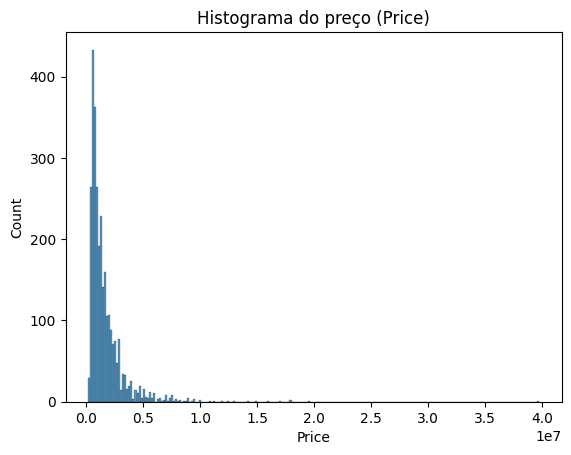

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data, x='Price').set_title('Histograma do preço (Price)')
plt.show()


Como o intervalo de preços é muito grande (em ordem de grandezas), faz sentido adotar o preço em escala logaritmica. Assim, valiamos o logaritmo do preço, e não o preço em si. Isso é feito para evitar que o modelo seja enviesado para os imóveis mais caros, que são poucos, e não generalize bem para os imóveis mais baratos, que são a maioria.

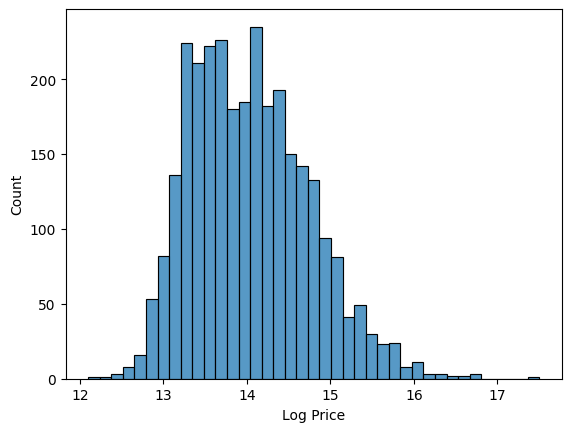

In [9]:
data['Log Price'] = np.log(data['Price'])
sns.histplot(data, x='Log Price')
plt.show()

### 1.2 Separação em Treino/Teste

Aqui, há a separação dos dados em treino e teste. Essa separação é feita antes da análise exploratória para que não haja vazamento de dados na engenharia de atributos. Assim, os dados de teste não são utilizados para a análise exploratória, e são utilizados apenas para a avaliação do modelo. Dessa maneira, é emulado um cenário real, em que o modelo é treinado com dados passados e testado com dados futuros.

Foi definido que os dados de teste representam 20% do total de dados disponíveis. Foi utilizado o atributo `random_state`, do `scikit-learn`, para que a separação seja sempre a mesma (em rodadas futuras do script), e não haja variação nos resultados.

In [10]:
from sklearn.model_selection import train_test_split

# target_variable = 'Price'
target_variable = 'Log Price'

X = data.drop(columns=['Price', 'Log Price'])
y = data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=23
)
train = pd.concat([X_train, y_train], axis='columns')
train.head()

,Location,Postal Code,Area,Bedrooms,Bathrooms,Receptions,City-County,House-Type,Log Price
2040,Northwood,HA6 2TA,2055,4,4,4,Middlesex,House,14.074021
1667,NaN,SW11 4EN,2235,5,5,5,London,House,14.731801
2050,Tadworth,KT20 6HZ,5380,6,6,6,Surrey,House,14.862830
744,Islington,N1 2HW,2216,4,4,4,London,House,15.068274
2683,NaN,SW11 4PT,2090,4,4,4,London,House,14.483340


Agora, há somente 2366 linhas no conjunto de dados de treino.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2366 entries, 2040 to 595
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Location     1685 non-null   category
 1   Postal Code  2366 non-null   category
 2   Area         2366 non-null   int64   
 3   Bedrooms     2366 non-null   int64   
 4   Bathrooms    2366 non-null   int64   
 5   Receptions   2366 non-null   int64   
 6   City-County  2366 non-null   category
 7   House-Type   2366 non-null   category
 8   Log Price    2366 non-null   float64 
dtypes: category(4), float64(1), int64(4)
memory usage: 232.2 KB


### 1.3 Valores Faltantes
Antes de realizar imputação de variáveis, devemos observar qual a proporção de valores faltantes nos dados apresentados. Isso é necessário pois etapas de inserção de dados faltantes funcionam melhor quando a porcentagem de valores faltantes é menor que 10% do conjunto de dados. Assim, analisamos a proporção de dados faltantes em cada coluna.

In [12]:
X_train.isna().sum() / len(X_train)

Location       0.287828
Postal Code    0.000000
Area           0.000000
Bedrooms       0.000000
Bathrooms      0.000000
Receptions     0.000000
City-County    0.000000
House-Type     0.000000
dtype: float64

Podemos decidir usar a variável Location com $28.8\%$ de dados faltantes, e realizar um método de imputação. O método de imputação será feito na etapa de formação do modelo, em que será utilizado um `Pipeline` no `scikit-learn` para realizar a imputação e a formação do modelo em um único passo.

### 1.4 Análise exploratória dos dados

Aqui, vamos fazer uma pequena análise exploratória dos dados, com o intuito de conhecer melhor a base de dados e ajudar nos processos de modelagem que serão desenvolvidos em sequência. A ideia é tentar inferir, visualmente, intuição sobre os dados e a relação entre as colunas e a variável alvo `Price`.

In [13]:
train = pd.concat([X_train,y_train], axis='columns')

/Users/kowalks/dev/cmc13-exame/env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


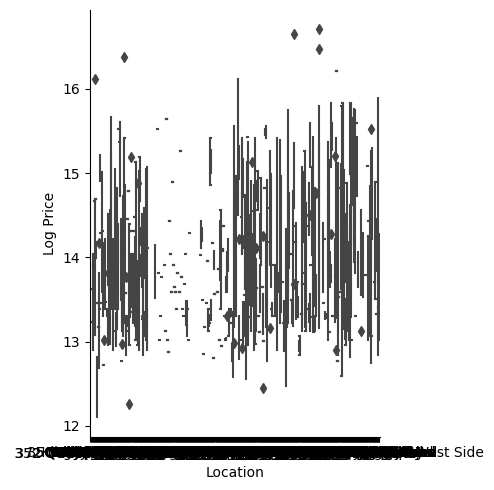

In [14]:
sns.catplot(data = train, x = 'Location', y = 'Log Price', kind='box')
#TODO: ajeitar isso

In [15]:
train.dtypes

Location       category
Postal Code    category
Area              int64
Bedrooms          int64
Bathrooms         int64
Receptions        int64
City-County    category
House-Type     category
Log Price       float64
dtype: object

In [16]:
train

,Location,Postal Code,Area,Bedrooms,Bathrooms,Receptions,City-County,House-Type,Log Price
2040,Northwood,HA6 2TA,2055,4,4,4,Middlesex,House,14.074021
1667,NaN,SW11 4EN,2235,5,5,5,London,House,14.731801
2050,Tadworth,KT20 6HZ,5380,6,6,6,Surrey,House,14.862830
744,Islington,N1 2HW,2216,4,4,4,London,House,15.068274
2683,NaN,SW11 4PT,2090,4,4,4,London,House,14.483340
...,...,...,...,...,...,...,...,...,...
1512,Ealing,W5 3HJ,904,2,2,2,London,New development,13.353475
1993,NaN,SW18 2HQ,693,1,1,1,London,Flat / Apartment,13.112313
1064,55 Primrose Hill Road,NW3 3EA,1752,2,2,2,London,Flat / Apartment,14.862830
742,Marylebone,W1H 4DR,1224,3,3,3,London,House,14.375126


<Axes: >

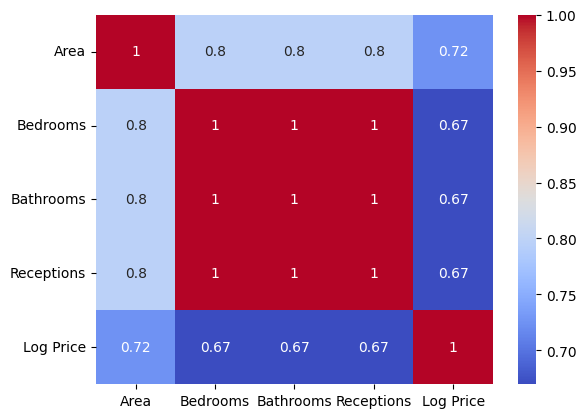

In [17]:
# Compute the correlation matrix
correlation_matrix = train.corr(numeric_only=True)

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

TODO: Escrever alguma coisa. Verificar se queremos deletar algumas redundâncias.

### 2. Modelo baseado em Árvores de Decisão ou Em Florestas Aleatórias (Random Forests)

Aqui, vamos fazer a formação de um modelo baseado em árvores de decisão ou em florestas aleatórias. A ideia é utilizar um modelo simples, que não necessite de muitos ajustes, para servir de baseline para os modelos mais complexos que serão desenvolvidos em seguida. Para fazer o ajuste dos hiperparâmetros, vamos fazer uma busca em grid (GridSearch). Para isso, vamos utilizar o método de validação cruzada (cross-validation) para avaliar o desempenho do modelo. O método de validação cruzada é utilizado para evitar o overfitting do modelo, e é feito dividindo o conjunto de treino em $k$ partes, e treinando o modelo em $k-1$ partes e testando em 1 parte. Esse processo é feito $k$ vezes, e o resultado final é a média dos resultados de cada iteração.

In [18]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
              #  'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
              #  'RF__bootstrap': bootstrap
               }
print(random_grid)

{'RF__n_estimators': [200, 400, 600, 800, 1000], 'RF__max_features': ['log2', 'sqrt'], 'RF__min_samples_split': [2, 5, 10], 'RF__min_samples_leaf': [1, 2, 4]}


Criação da pipeline de Random Forest incluindo métodos de imputação e codificação de variáveis aleatórias.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import encoding as ce
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# Imputação de valores faltantes em variáveis categóricas
RF_pipeline = Pipeline([
    # Imputação da variável categórica Location
    ('imputer_cat', mdi.CategoricalImputer(variables='Location')),
    # Encoding de labels raras
    ('encoder_rare_label', ce.RareLabelEncoder(tol=0.01, n_categories=2, variables=category_columns)),
    # Encoding de variáveis categóricas (One-Hot)
    ('categorical_encoder', ce.OneHotEncoder(variables=category_columns)),
    # Random Forest Regressor
    ('RF', RandomForestRegressor(random_state=23))
])

Definição do Grid Search utilizado considerando a pipeline criada anteriormente e um KFLod de 5.

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, make_scorer
score_method = {"MAPE":'neg_mean_absolute_percentage_error', "RMSE":"neg_root_mean_squared_error","R2":'r2'}
scv = KFold()
RF_grid_search = GridSearchCV(RF_pipeline,
                              param_grid = random_grid,
                              cv
                              = scv,
                              n_jobs = -1,
                              scoring = score_method,
                              refit = "MAPE")

Treinamento da pipeline com o Grid Search.

In [21]:
RF_grid_search.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer_cat',
                                        CategoricalImputer(variables='Location')),
                                       ('encoder_rare_label',
                                        RareLabelEncoder(n_categories=2,
                                                         tol=0.01,
                                                         variables=['Location',
                                                                    'Postal '
                                                                    'Code',
                                                                    'City-County',
                                                                    'House-Type'])),
                                       ('categorical_encoder',
                                        OneHotEncoder(variables=['Location',
                                                                 'Postal Code',
                                                                 'City-County',
                                                                 'House-Type'])),
                                       ('RF',
                                        RandomForestRegressor(random_state=23))]),
             n_jobs=-1,
             param_grid={'RF__max_features': ['log2', 'sqrt'],
                         'RF__min_samples_leaf': [1, 2, 4],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [200, 400, 600, 800, 1000]},
             refit='MAPE',
             scoring={'MAPE': 'neg_mean_absolute_percentage_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

Melhores parâmetros encontrados pelo Grid Search.

In [22]:
RF_grid_search.best_params_


{'RF__max_features': 'sqrt',
 'RF__min_samples_leaf': 2,
 'RF__min_samples_split': 5,
 'RF__n_estimators': 400}

Comparação das métricas de cada modelo fittado pelo Grid Search em termos do MAPE (Mean Absolute Percentual Error). Aqui, estamos analisando qual é o range de MAPEs possíveis nos modelos gerados pelo grid search com o kfold especificado.

$\text{MAPE}(y, \hat{y}) = \frac{100\%}{N} \sum_{i=0}^{N - 1} \frac{|y_i - \hat{y}_i|}{y_i}.$ 

<Axes: >

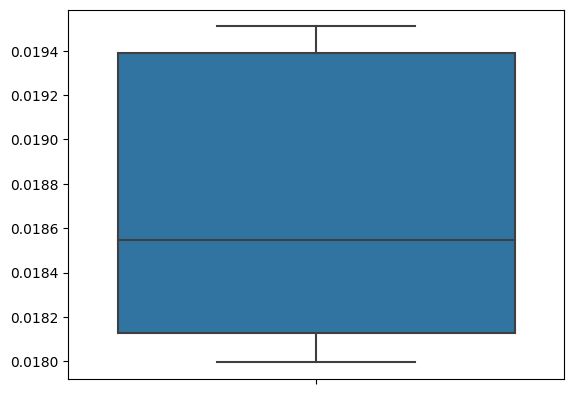

In [23]:
# Get the best estimator
best_estimator = RF_grid_search.best_estimator_

# Perform cross-validation and get the results
cv_results = RF_grid_search.cv_results_

sns.boxplot(y=(-1)*cv_results['mean_test_MAPE'])

Agora, fazendo as métricas de avaliação do modelo. Aqui, vamos utilizar o conjunto de teste para avaliar o modelo. O conjunto de teste não foi utilizado em nenhum momento do processo de modelagem, e foi separado no início do processo. Assim, o modelo não foi treinado com os dados de teste, e não houve vazamento de dados.

In [24]:
best_random = RF_grid_search.best_estimator_
predictions_rf = best_random.predict(X_test)

In [25]:
def regression_metrics(model_predicted, y_test,model_name):
    rmse_ = np.sqrt(metrics.mean_squared_error(model_predicted,y_test))
    r2 = metrics.r2_score(y_test, model_predicted)
    mape = metrics.mean_absolute_percentage_error(y_test, model_predicted)
    print(model_name," RMSE: ", rmse_)
    print(model_name,"R2: " + str(r2))
    print(model_name,"MAPE: " + str(mape))
    return rmse_, r2, mape

def actual_vs_pred_plot(y_train,y_pred,model_name):

    fig = plt.figure(figsize=(12,12))
    fig, ax = plt.subplots()

    ax.scatter(y_train, y_pred,color = "teal",edgecolor = 'lightblue')
    ax.plot([y_train.min(),y_train.max()], [y_train.min(), y_train.max()], 'k--',lw=0.2)
    ax.set_xlabel('Atual')
    ax.set_ylabel('Predito')
    plt.suptitle(model_name + ' - Actual vs Predicted Values',size=14)
    plt.show()

def model_dist_plot(y_test,y_pred,model_name):
    plt.figure(figsize=(10,5))
    sns.histplot(y_test, kde=False)
    sns.histplot(y_pred, kde=False)
    plt.title(model_name + ' - Distribution Plot')
    plt.legend(labels=['', 'Actual Values of Price', '', 'Predicted Values of Price'])
    # plt.xlim(0,)

def model_residual_plot(test_Y,model_predicted,model_name):
    residuals = test_Y - model_predicted
    plt.scatter(model_predicted, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(model_name + ' - Residual Plot')
    plt.show()

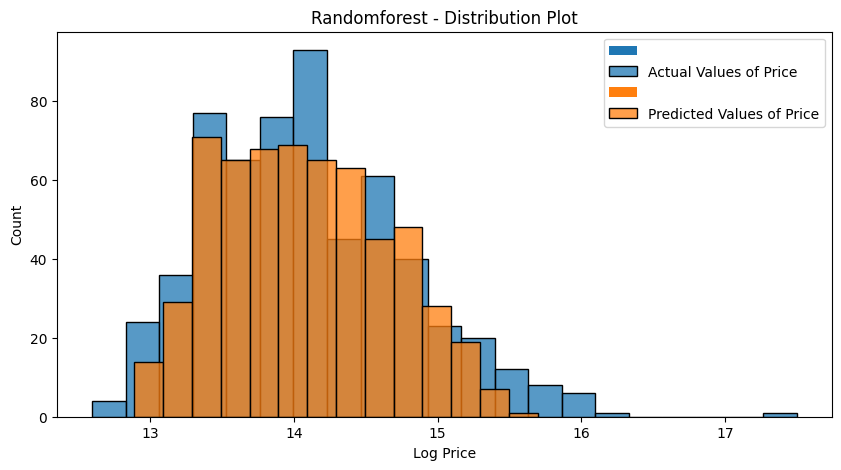

In [26]:
model_dist_plot(y_test, predictions_rf, 'Randomforest')

### 3. Modelo baseado em Redes Neurais do tipo MLP (MultiLayer Perceptron)

Aqui, fazemos o treinamento do modelo com Redes Neurais do tipo MLP, utilizando o framework do sckit-learn e do Keras. A fim de comparação, será feita a análise somente com o do skit-learn, já que ele já implementa métricas mais adequadas para o problema de regressão.

#### 3.1 Rede Neural com Keras

In [27]:
from tensorflow.keras import layers, activations,losses
from tensorflow.keras.models import Sequential

lambda_l2 = 0
def create_model(input_shape):
    model = Sequential()
    model.add(layers.Dense(19, activation=activations.relu, input_shape=(input_shape, )))
    model.add(layers.Dense(19, activation=activations.relu))
    model.add(layers.Dense(19, activation=activations.relu))
    model.add(layers.Dense(19, activation=activations.relu))
    model.add(layers.Dense(1, activation=activations.linear))
    model.summary()
    model.compile(optimizer="adam", loss=losses.mse, metrics=["accuracy"])
    return model

In [28]:
model = create_model(X_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19)                171       
                                                                 
 dense_1 (Dense)             (None, 19)                380       
                                                                 
 dense_2 (Dense)             (None, 19)                380       
                                                                 
 dense_3 (Dense)             (None, 19)                380       
                                                                 
 dense_4 (Dense)             (None, 1)                 20        
                                                                 
Total params: 1331 (5.20 KB)
Trainable params: 1331 (5.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-07-14 00:35:02.120715: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-14 00:35:02.120742: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-07-14 00:35:02.120748: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-07-14 00:35:02.121230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-14 00:35:02.121904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 3.2 Rede Neural com Scikit-Learn

Criamos o mesmo pipeline anteriormente criado para o RL, mas agora com o modelo de rede neural do scikit-learn. Além disso, criamos um param grid search.

In [29]:
from sklearn.neural_network import MLPRegressor
from itertools import combinations

# Imputação de valores faltantes em variáveis categóricas
MLP_pipeline = Pipeline([
    # Imputação da variável categórica Location
    ('imputer_cat', mdi.CategoricalImputer(variables='Location')),
    # Encoding de labels raras
    ('encoder_rare_label', ce.RareLabelEncoder(tol=0.01, n_categories=2, variables=category_columns)),
    # Encoding de variáveis categóricas (One-Hot)
    ('categorical_encoder', ce.OneHotEncoder(variables=category_columns)),
    # Random Forest Regressor
    ('MLP', MLPRegressor(random_state=22, max_iter=10000))
])

hidden_layer_sizes = list(combinations([16, 32, 64, 128], 3))
activation = ['relu', 'tanh']
alpha = [0.1, 0.01, 0.001]

mlp_grid = {
    'MLP__hidden_layer_sizes': hidden_layer_sizes,
    'MLP__activation': activation,
    'MLP__alpha': alpha,
}

MLP_grid_search = GridSearchCV(
    MLP_pipeline,
    param_grid = mlp_grid,
    cv = scv,
    n_jobs = -1,
    scoring = score_method,
    refit = "MAPE"
)

Treinamento da Pipeline com o MLP param Search.

In [30]:
MLP_grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer_cat',
                                        CategoricalImputer(variables='Location')),
                                       ('encoder_rare_label',
                                        RareLabelEncoder(n_categories=2,
                                                         tol=0.01,
                                                         variables=['Location',
                                                                    'Postal '
                                                                    'Code',
                                                                    'City-County',
                                                                    'House-Type'])),
                                       ('categorical_encoder',
                                        OneHotEncoder(variables=['Location',
                                                                 'Postal Code',
                                                                 'City-County',
                                                                 'House-Type'])),
                                       ('MLP',
                                        MLPRegressor(max_iter=10000,
                                                     random_state=22))]),
             n_jobs=-1,
             param_grid={'MLP__activation': ['relu', 'tanh'],
                         'MLP__alpha': [0.1, 0.01, 0.001],
                         'MLP__hidden_layer_sizes': [(16, 32, 64),
                                                     (16, 32, 128),
                                                     (16, 64, 128),
                                                     (32, 64, 128)]},
             refit='MAPE',
             scoring={'MAPE': 'neg_mean_absolute_percentage_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

Definição do melhor modelo encontrado pelo Grid Search.

In [31]:
MLP_grid_search.best_params_


{'MLP__activation': 'tanh',
 'MLP__alpha': 0.1,
 'MLP__hidden_layer_sizes': (32, 64, 128)}

Comparação das métricas de cada modelo fittado pelo Grid Search em termos do MAPE (Mean Absolute Percentual Error). Aqui, estamos analisando qual é o range de MAPEs possíveis nos modelos gerados pelo grid search com o kfold especificado.

$\text{MAPE}(y, \hat{y}) = \frac{100\%}{N} \sum_{i=0}^{N - 1} \frac{|y_i - \hat{y}_i|}{y_i}.$ 

<Axes: >

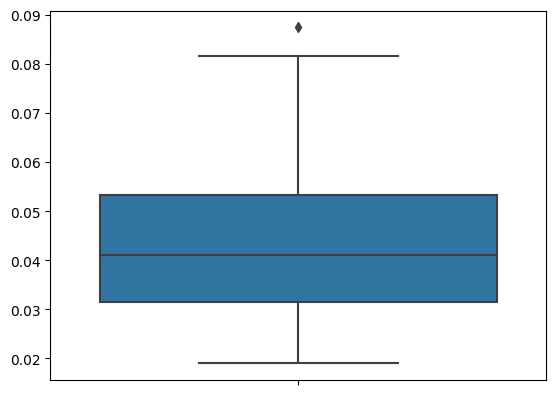

In [32]:
# Get the best estimator
best_estimator_MLP = MLP_grid_search.best_estimator_

# Perform cross-validation and get the results
cv_results_MLP = MLP_grid_search.cv_results_

sns.boxplot(y=(-1)*cv_results_MLP['mean_test_MAPE'])

Agora, fazendo as métricas de avaliação do modelo. Aqui, vamos utilizar o conjunto de teste para avaliar o modelo. O conjunto de teste não foi utilizado em nenhum momento do processo de modelagem, e foi separado no início do processo. Assim, o modelo não foi treinado com os dados de teste, e não houve vazamento de dados.

Modelo de MLP


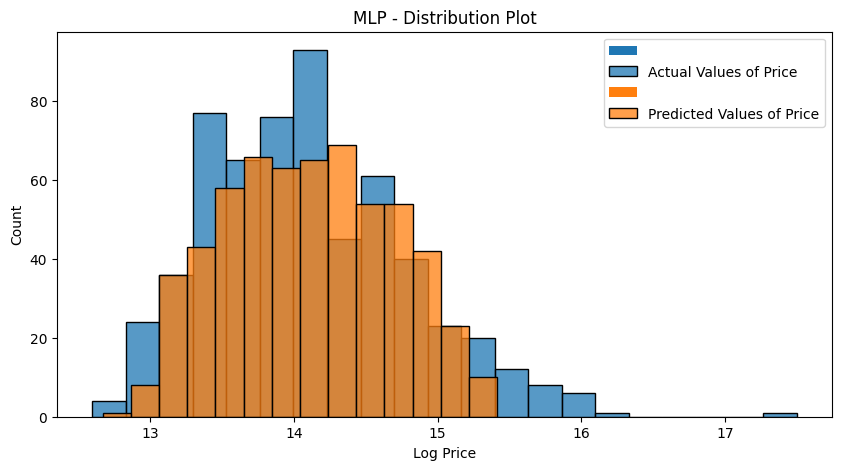

<Figure size 1200x1200 with 0 Axes>

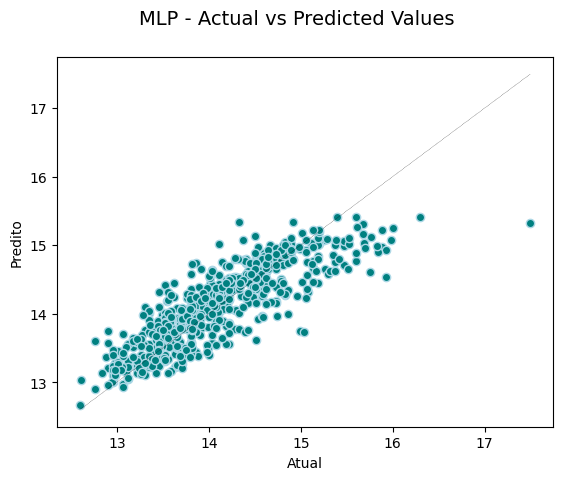

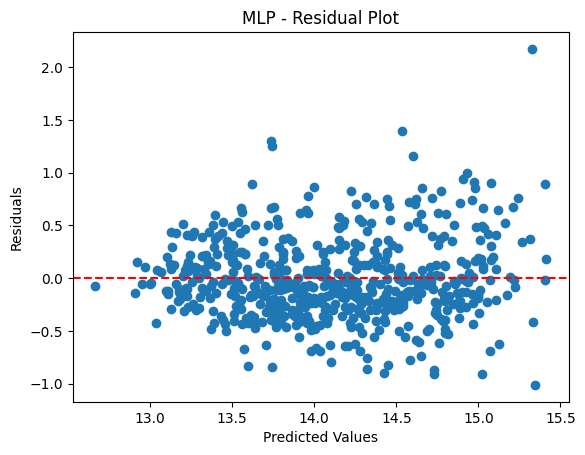

In [33]:
best_mlp = MLP_grid_search.best_estimator_
predictions_mlp = best_mlp.predict(X_test)

print('Modelo de MLP')
# rmse, r2, mape = regression_metrics(predictions_mlp, y_test,'MLP')

model_dist_plot(y_test, predictions_mlp, 'MLP')

actual_vs_pred_plot(y_test, predictions_mlp,'MLP')

# Create residual plot
model_residual_plot(y_test, predictions_mlp, 'MLP')

### 4. Análise Comparativa do desempenho dos modelos

Observando os resultados, pode-se concluir que o modelo de Random Forest apresentou um desempenho melhor que o modelo de MLP. Isso pode ser explicado pelo fato de que o modelo de Random Forest é mais robusto a outliers e a dados faltantes, já que ele utiliza a média dos valores de cada folha para fazer a predição. Além disso, o modelo de Random Forest é mais simples de ser treinado, já que não há necessidade de ajustar alguns hiperparâmetros de otimização, como o learning rate, por exemplo. No entanto, foi necessário ajustar hiperparâmetros como o número de árvores e a profundidade máxima de cada árvore.

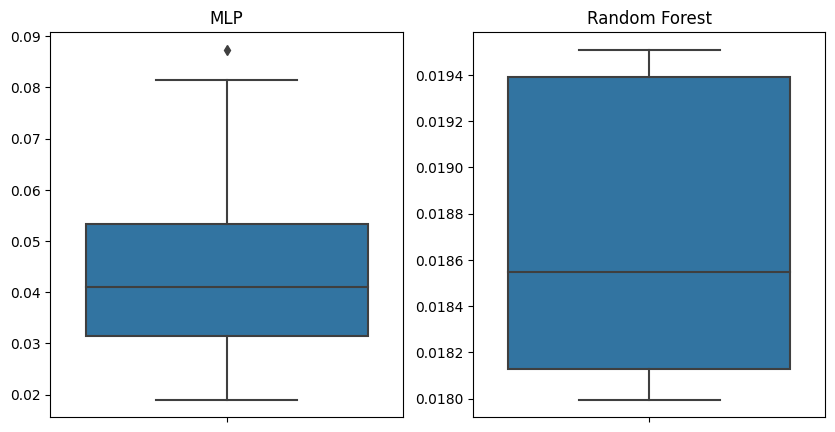

In [34]:
# Create two boxplots side by side using seaborn
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y=(-1)*cv_results_MLP['mean_test_MAPE'], ax=axes[0])
sns.boxplot(y=(-1)*cv_results['mean_test_MAPE'], ax=axes[1])
axes[0].set_title('MLP')
axes[1].set_title('Random Forest')
plt.show()

Olhando para as métricas de comparação, percebe-se que o Random Forest tem um R2 maior, um RMSE menor e um MAPE menor. Isso indica que o modelo de Random Forest apresenta um desempenho melhor que o modelo de MLP em termos das métricas de comparação.

In [35]:
print('Modelo Random Forest')
rmse, r2, mape = regression_metrics(predictions_rf, y_test,'Randomforest')

print('\nModelo MLP')
rmse, r2, mape = regression_metrics(predictions_mlp, y_test,'MLP')

Modelo Random Forest
Randomforest  RMSE:  0.3606248253925123
Randomforest R2: 0.7378751388614475
Randomforest MAPE: 0.018721369310626658

Modelo MLP
MLP  RMSE:  0.3794414331150625
MLP R2: 0.7098073042936659
MLP MAPE: 0.020318445486409077


Olhando para as curvas de actual vs predicted, pode-se observar que ambos os modelos tiveram dificuldades de aprender os outliers, mesmo com a utilização de métodos de imputação de dados faltantes. Isso pode ser explicado pelo fato de que há poucos dados no extremo dos intervalos. Assim, mesmo para um modelo robusto como o Random Forest, é difícil aprender a relação entre as variáveis e o preço dos imóveis no extremo.

Em ambos os casos, quando o preço real do imóvel era muito grande, os modelos tendiam a subpreciar o imóvel.

<Figure size 1200x1200 with 0 Axes>

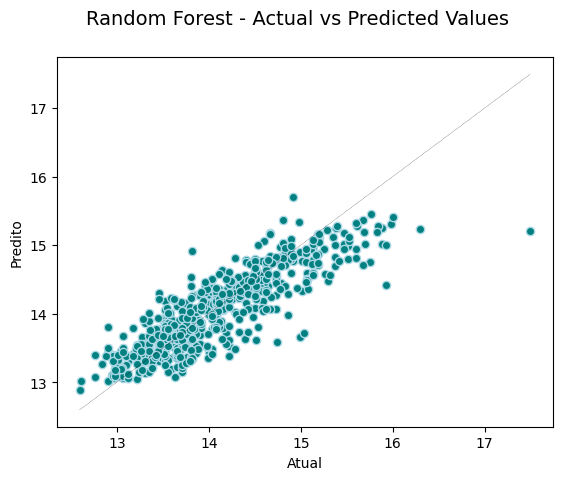

<Figure size 1200x1200 with 0 Axes>

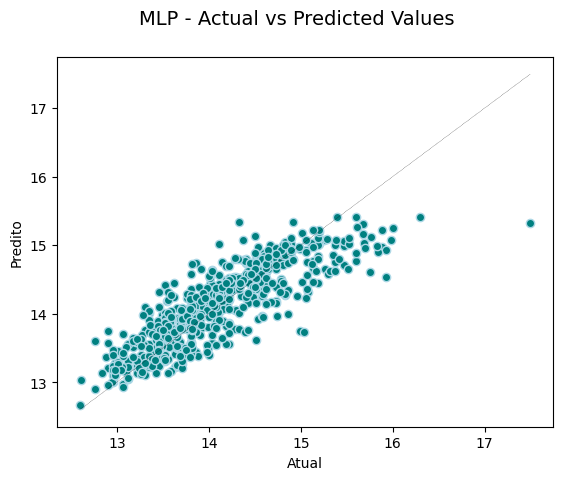

In [36]:
actual_vs_pred_plot(y_test, predictions_rf,'Random Forest')
actual_vs_pred_plot(y_test, predictions_mlp,'MLP')

Por fim, olhando para os gráficos de erros residuais, observa-se uma distribuição homogênea dos erros, o que indica que os modelos não apresentaram nenhum tipo de viés aparente. Os valores preditos tem a mesma probabilidade de serem maiores ou menores que os valores reais.

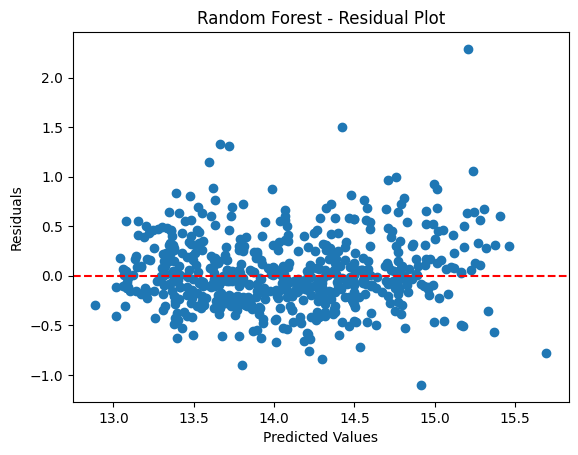

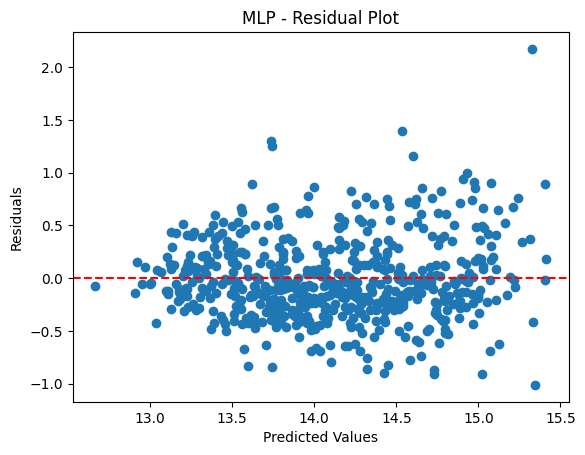

In [37]:
model_residual_plot(y_test, predictions_rf, 'Random Forest')
model_residual_plot(y_test, predictions_mlp, 'MLP')

### 5. Aplicação da predição do Modelo Desenvolvido

Aqui, vamos crear um código para uso do modelo desenvolvido aplicado a um arquivo com o mesmo formato do arquivo de dados fornecido (UK_real_estate.csv). O nome do arquivo de dados de testes será `UK_real_estate_test.csv`. Perceba que, além do predict do modelo, é necessário transformar de volta a variával `Log Price` para `Price`. Por isso, foi aplicada a função `np.exp()`.

In [38]:
# Perceba que esse código não lê a coluna `Price`, já que ela não é necessária para o predict do modelo.

columns = {
    'Location': str,
    'Postal Code': str,
    'Area': np.int64,
    'Bedrooms': np.int64,
    'Bathrooms': np.int64,
    'Receptions': np.int64,
    'City-County': str,
    'House-Type': str,
}
data_test = pd.read_csv('UK_real_estate_test.csv', index_col=False, usecols=columns.keys(), dtype=columns)
test_rf = np.exp(best_estimator.predict(data_test))
test_mlp = np.exp(best_estimator_MLP.predict(data_test))

#### 5.1 Teste para o Random Forest

In [39]:
test_rf

array([2284650.03857615,  719143.98923604,  663372.32871501])

#### 5.2 Teste oara o MLP

In [40]:
test_mlp

array([2393269.11651164,  790626.65073256,  629416.56144344])

### 6. Conclusões

Nesse trabalho, foi possível fazer uma comparação do desempenho de dois modelos de regressão: Random Forest e MLP. O modelo de Random Forest apresentou um desempenho melhor que o modelo de MLP, em termos das métricas de comparação. Isso pode ser explicado pelo fato de que o modelo de Random Forest é mais robusto a outliers e a dados faltantes, já que ele utiliza a média dos valores de cada folha para fazer a predição. Além disso, o modelo de Random Forest é mais simples de ser treinado, já que não há necessidade de ajustar alguns hiperparâmetros de otimização, como o learning rate, por exemplo. No entanto, foi necessário ajustar hiperparâmetros como o número de árvores e a profundidade máxima de cada árvore.

Esse desempenho foi avaliado conforme as métricas de comparação: R2, RMSE e MAPE. Além disso, foi feita uma análise visual dos erros residuais e das curvas de actual vs predicted para os dois modelos.

Percebe-se que foi necessário fazer um pouco de *feature engineering* e preparação dos dados para que o modelo se comportasse de maneira desejada. Foi necessário fazer a imputação de dados faltantes, o encoding das variáveis categóricas em `OneHotEncoding` e o encoding com labels raras. Além disso, foi necessário fazer a transformação logarítmica da variável `Price`, para que o modelo se comportasse de maneira mais adequada.

Por fim, percebeu-se que é bem fácil fazer a aplicação de modelos de Ciência de Dados utilizando o Python. As bibliotecas do `scikit-learn` implementam já vários modelos de Machine Learning, e é bem fácil fazer a aplicação deles. Além disso, é bem fácil fazer a avaliação dos modelos, já que o `scikit-learn` implementa várias métricas de avaliação. Por fim, é bem fácil fazer a aplicação do modelo em um arquivo de dados de teste, já que o `scikit-learn` implementa a função `predict()`.